# Extract LCD example
This notebooks is a step-by-step description of a method used to extract the region of LCD-display from an image. This method is based exclusively on computer vision techniques and meant to be a preliminary preprocessing step before using a digit detector down the pipeline in order to read numbers from an LCD-image.

## Import required libraries

In [1]:
# from labels import DICT_INIT
import os
import numpy as np
from matplotlib import pyplot as plt
from skimage import io, measure, util, filters, transform, draw, color
from preprocess import utils, transformation, plots
from extract_lcd import extract_display

## Specify image

In [2]:
# ============================================================================
# ========================== TEST SINGLE IMG =================================
# ============================================================================

# 0. Define image path
path = '/home/aboumessouer/Downloads/YUVA_EB_DATASET/RAW_IMAGES/1_Day_Light/001.JPG'
# path = '/home/aboumessouer/Downloads/YUVA_EB_DATASET/RAW_IMAGES/1_Day_Light/002.JPG'
# path = '/home/aboumessouer/Downloads/YUVA_EB_DATASET/RAW_IMAGES/1_Day_Light/003.JPG'
# path = '/home/aboumessouer/Downloads/YUVA_EB_DATASET/RAW_IMAGES/1_Day_Light/006.JPG'
# path = '/home/aboumessouer/Downloads/YUVA_EB_DATASET/RAW_IMAGES/1_Day_Light/007.JPG'
# path = '/home/aboumessouer/Downloads/YUVA_EB_DATASET/RAW_IMAGES/2_Night/065.JPG'
# path = '/home/aboumessouer/Downloads/YUVA_EB_DATASET/RAW_IMAGES/1_Day_Light/018.JPG'
# path = '/home/aboumessouer/Downloads/YUVA_EB_DATASET/RAW_IMAGES/1_Day_Light/012.JPG'
# path = '/home/aboumessouer/Downloads/YUVA_EB_DATASET/RAW_IMAGES/1_Day_Light/046.JPG'
# path = '/home/aboumessouer/Downloads/YUVA_EB_DATASET/RAW_IMAGES/2_Night/053.JPG'


# DEFAULT PARAMETERS
DEFAULT_IMAGE_SHAPE = (450, 800, 3)

## 1. Read RGB image as float, resize and convert to HSV

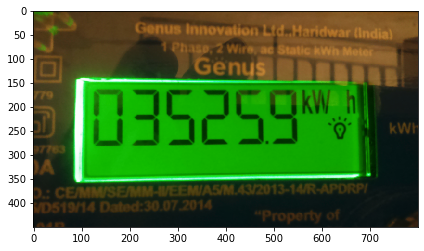

In [3]:
# 1. Read RGB image as float, resize and convert to HSV ====================
img = util.img_as_float64(io.imread(path))
img = transform.resize(img, output_shape=DEFAULT_IMAGE_SHAPE)
img_hsv = color.rgb2hsv(img)
io.imshow(img)

### Plot individual HSV-channels, histograms and binary thresholded images

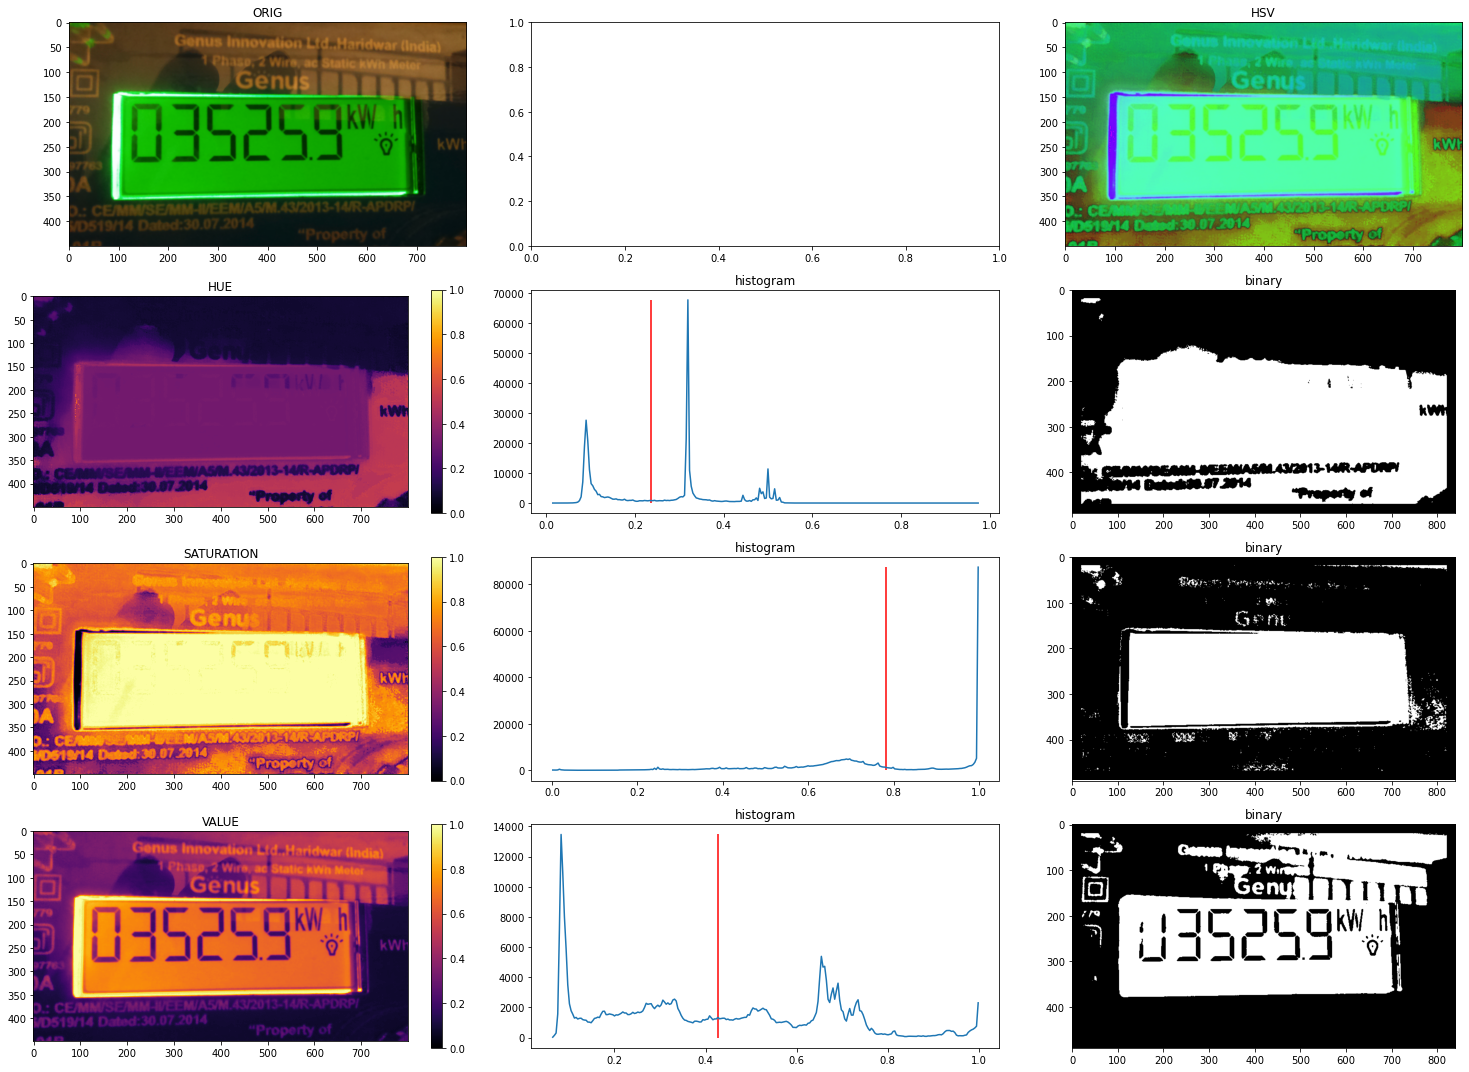

In [4]:
# Plot HSV ===================================================================
_ = plots.plot_hsv_hist_binary(img)

## 2. Select best HSV-Channel for thresholding
From the plots above, we can with our naked eyes see that the best LCD segmentation was obtained from the saturation HSV-channel. This is not always the case; other hsv-channels can be more suited for other images. Therefore, this channel is selected for further analysis. This selection is done manually at this stage for since the focus is on presenting the entire method. In the implementation below, the hsv-channel selection is done automatically.

Text(0.5, 1.0, 'binary')

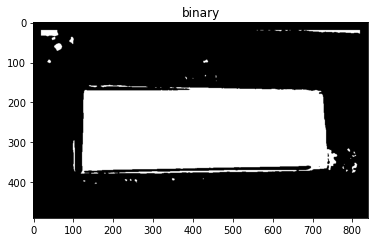

In [5]:
# 2. Threshold one HSV-channel -> Binary Channel =============================
img_ch = img_hsv[:, :, 1]
img_ch = filters.gaussian(img_ch, sigma=2)
th = filters.threshold_otsu(img_ch)
binary = img_ch > th
binary = utils.pad_binary_image(binary, dh=20, dw=20)
# plot -----------------------------------------------------------------------
plt.imshow(binary, cmap="gray")
plt.title("binary")

## 3. Find LCD contour

Text(0.5, 1.0, 'contour + mask + vertices')

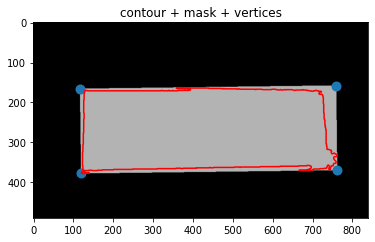

In [6]:
# 3. Compute Contour in Binary Channel and select biggest Contour ============
# contours_s = measure.find_contours(binary_s, level=0)
cnts = measure.find_contours(util.img_as_float(binary), level=0.9)
k = np.argmax([cnt.shape[0] for cnt in cnts])
cnt_max = cnts[k]
mask = draw.polygon2mask(binary.shape[0:2], cnt_max)
rect = transformation.minimum_bounding_rectangle(cnt_max)
mask_rect = draw.polygon2mask(binary.shape[0:2], rect)

# bg_black = np.zeros(shape=binary.shape[0:2], dtype="bool")
fig, ax = plt.subplots()
ax.imshow(0.7*util.img_as_float(mask_rect), vmin=0.0, vmax=1.0, cmap="gray")
ax.plot(cnt_max[:, 1], cnt_max[:, 0], color="r")
ax.scatter(rect[:, 1], rect[:, 0], linewidths=4)
# ax.scatter(rect[:,0], rect[:,1], linewidths=4)
ax.set_title("contour + mask + vertices")

## 4. Extract LCD

Text(0.5, 1.0, 'img_lcd')

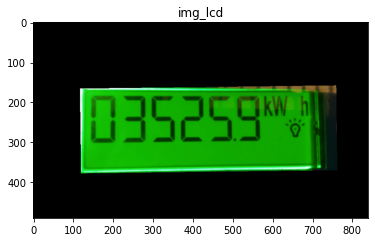

In [7]:
# 4. Extract lcd image ========================================================
img_lcd = utils.pad_image(img)
img_lcd[np.dstack(3*[~mask_rect])] = 0.0
# plot -----------------------------------------------------------------------
plt.imshow(img_lcd)
plt.title("img_lcd")

# Overview

In [10]:
img_name = "/".join(path.split("/")[-1:])
img = util.img_as_float64(io.imread(path))

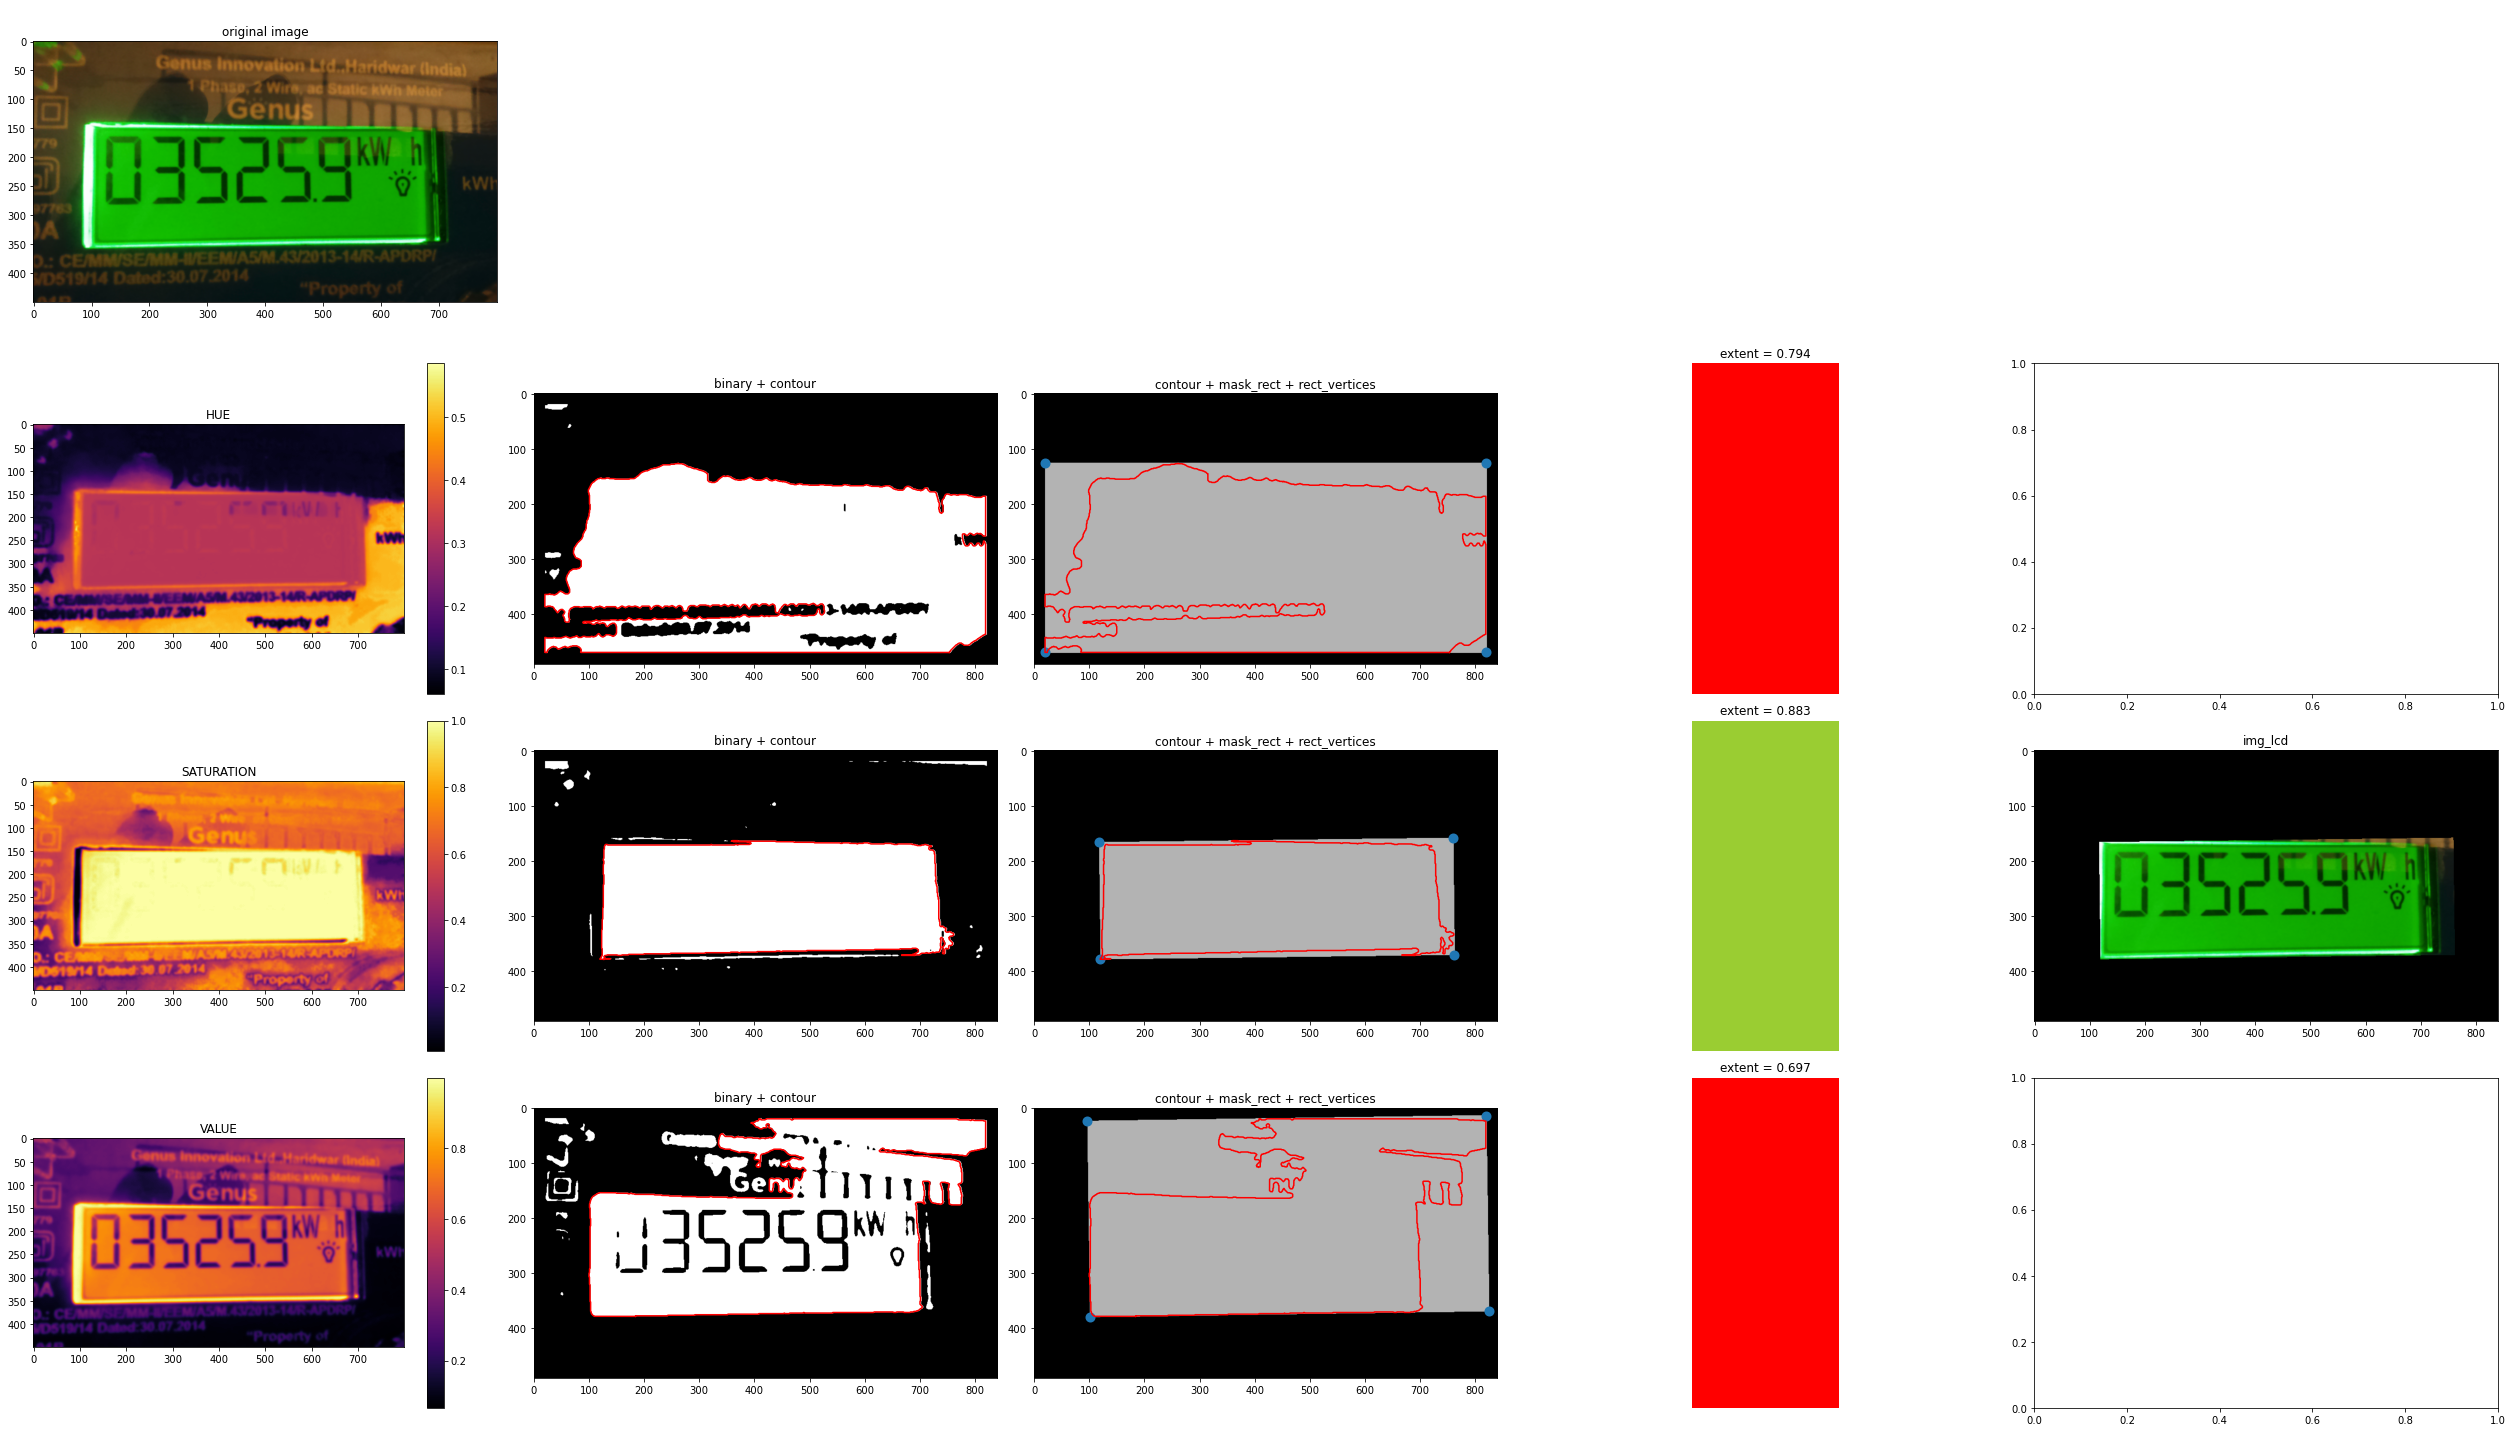

In [11]:
img_lcd, mask_rect, contour = extract_display(img, img_name, shape=DEFAULT_IMAGE_SHAPE, plot=True)